In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import datetime
import numpy as np

In [2]:
data_order = pd.read_csv(r'C:\Users\leand\Desktop\Data Science (Henry)\Proyectos\Proyecto_grupal\DS-Proyecto_Grupal_Olist\data_normalizada\data_order.csv')

lista = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in lista:
     data_order[i] = pd.to_datetime(data_order[i]).round('s')

     
item = pd.read_csv(r'C:\Users\leand\Desktop\Data Science (Henry)\Proyectos\Proyecto_grupal\DS-Proyecto_Grupal_Olist\data_normalizada\item.csv')

item['total'] = item['price'] * item['quantity']
df = data_order[['order_id','order_purchase_timestamp']].merge(item[['order_id', 'total']], on ='order_id')
df = df[['order_purchase_timestamp','total']]

In [3]:
df.rename(columns = {'order_purchase_timestamp' : 'ds', 'total' : 'y'}, inplace= True) 

# Análisis exploratorio de datos

Necesitamos identificar los componentes de nuestra serie de tiempo, ya que para poder predecir con mayor precisión el nivel de ventas en un futuro primero es importante comprender cómo se han comportado nuestros datos hasta ese momento

Trabajaremos con una serie de tiempo univariable, ya que vamos a considerar el nivel de ventas (variable dependiente) a lo largo del tiempo (variable independiente)

Vale señalar que la calidad de la predicción dependerá en gran parte de las características del sistema y de la predictibilidad de su comportamiento (qué tan predecible es)

In [4]:
# Ordeno la fecha para que aparezca en orden ascendente

df.sort_values('ds', inplace= True)

In [5]:
df.head(10)

ds       y
5085   2016-09-04 21:15:19   39.99
5086   2016-09-04 21:15:19   65.80
4925   2016-09-05 00:15:34   59.50
34803  2016-09-15 12:16:38   89.98
34804  2016-09-15 12:16:38  134.97
34802  2016-09-15 12:16:38   44.99
93991  2016-10-02 22:07:52  100.00
105636 2016-10-03 09:44:50   29.90
32183  2016-10-03 16:56:50   21.90
104879 2016-10-03 21:01:41   21.50

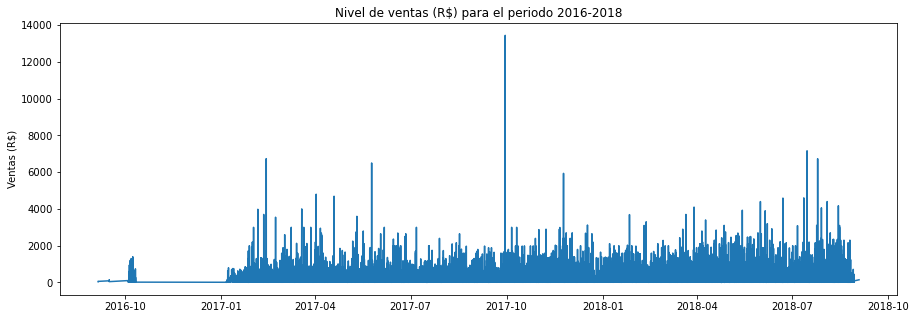

In [6]:
plt.figure(figsize = (15,5))
plt.plot(df.ds, df.y)
plt.title('Nivel de ventas (R$) para el periodo 2016-2018')
plt.ylabel('Ventas (R$)')
plt.show()

La serie se ve con ruido o saturada porque estamos evaluando un periodo de dos años que incluyen, en algunos casos, varias mediciones en un mismo día

Frecuencia de muestro : cada cuánto tiempo se registra un nuevo dato, o en otras palabras, cuánto tiempo hay entre un dato y el siguiente

Tenemos una ventana de tiempo de dos años (09-2016 a 09-2018), pero la frecuencia de muestreo no es constante. Quizás en un día tenemos 3 órdenes y luego no tenemos medición por una semana completa.

Como la frecuencia de muestro no es equiespaciada (o es muy inestable), agrupamos las ventas por semana.

Esto se conoce como resampleo, que es el proceso de resumir los datos temporales. De esta forma, se logra suavizar el gráfico. Básicamente, agrupa los datos por intervalos de tiempo

Lo que hacemos aquí es pasar de una frecuencia de muestro más chica (e inestable, porque no es constante) a una más grande.

In [5]:
semanal = df.resample('W', on = 'ds').mean()
semanal.head()

y
ds                 
2016-09-04   52.895
2016-09-11   59.500
2016-09-18   89.980
2016-09-25      NaN
2016-10-02  100.000

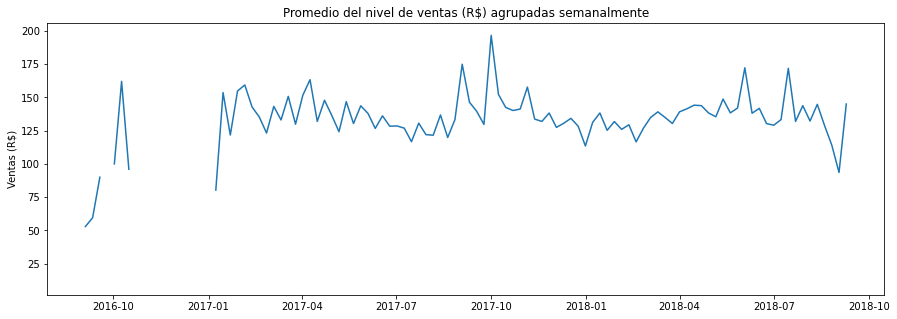

In [165]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.y)
plt.title('Promedio del nivel de ventas (R$) agrupadas semanalmente')
plt.ylabel('Ventas (R$)')
plt.show()

In [59]:
#df['date_check'] = df.ds.diff()
#df.date_check.value_counts()

In [55]:
# Busco las semanas en las que no hay registros de ventas

semanal.isnull().sum()

y    11
dtype: int64

In [56]:
# Observamos que las semanas sin datos se ubican en los últimos dos meses de 2016. Conviene arrancar la siere temporal directamente en enero 2017

semanal[semanal.y.isnull()]

y
ds            
2016-09-25 NaN
2016-10-23 NaN
2016-10-30 NaN
2016-11-06 NaN
2016-11-13 NaN
2016-11-20 NaN
2016-11-27 NaN
2016-12-04 NaN
2016-12-11 NaN
2016-12-18 NaN
2017-01-01 NaN

In [7]:
# resampleo la frecuencia de muestro a mensual

mensual = df.resample('M', on = 'ds').mean()

Text(0.5, 1.0, 'Promedio del nivel de ventas por mes')

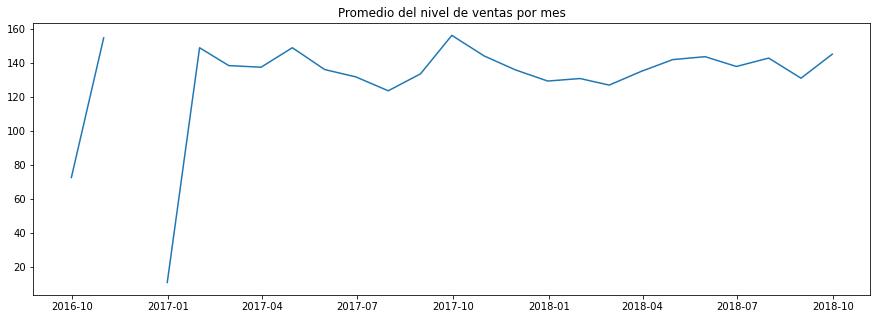

In [69]:
plt.figure(figsize = (15,5))
plt.plot(mensual.index, mensual.y)
plt.title('Promedio del nivel de ventas por mes')
plt.ylabel('Ventas (R$)')

### **Trabajaremos sobre la serie semanal promedio. Sacamos outliers, si es que hay, y rellenamos valores faltantes**

In [151]:
print(semanal.isna().sum())

#Esta parte la desechamos, porque interpolate impulta los faltantes de una manera que distorsiona nuestra tendencia inicial
#semanal = semanal.interpolate()
#print(semanal.isna().sum())

y    11
dtype: int64


In [6]:
semanal = semanal[semanal.index > '2017-01-01']

In [8]:
# Media movil. La ventana define la cantidad de registros anteriores + registro actual que necesita para realizar el promedio en la fila actual

# SIRVE PARA DEFINIR LAS TENDENCIAS A LARGO PLAZO DE UNA SERIE DE TIEMPO

ventana = int(10)
semanal_promedio_tendencia = semanal.y.rolling(window=ventana, center = True).mean()
semanal_promedio_tendencia

ds
2017-01-08           NaN
2017-01-15           NaN
2017-01-22           NaN
2017-01-29           NaN
2017-02-05           NaN
                 ...    
2018-08-12    133.922142
2018-08-19           NaN
2018-08-26           NaN
2018-09-02           NaN
2018-09-09           NaN
Freq: W-SUN, Name: y, Length: 88, dtype: float64

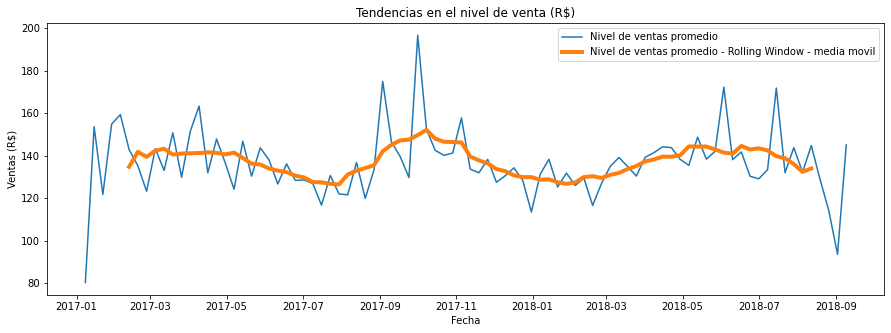

In [8]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.y, label = 'Nivel de ventas promedio')
plt.plot(semanal_promedio_tendencia, lw = 4, label = 'Nivel de ventas promedio - Rolling Window - media movil')
plt.xlabel('Fecha')
plt.ylabel('Ventas (R$)')
plt.legend()
plt.title('Tendencias en el nivel de venta (R$)')
plt.show()

In [9]:
# PROBAMOS CON OTRA VENTANA

ventana = int(12)
semanal_promedio_tendencia = semanal.y.rolling(window=ventana, center = True).mean()

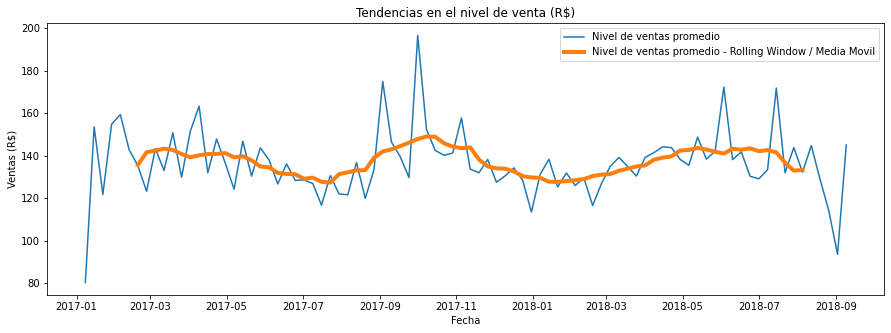

In [10]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.y, label = 'Nivel de ventas promedio')
plt.plot(semanal_promedio_tendencia, lw = 4, label = 'Nivel de ventas promedio - Rolling Window / Media Movil')
plt.xlabel('Fecha')
plt.ylabel('Ventas (R$)')
plt.legend()
plt.title('Tendencias en el nivel de venta (R$)')
plt.show()

*La tendencia parecería seguir una función sinusoidal*

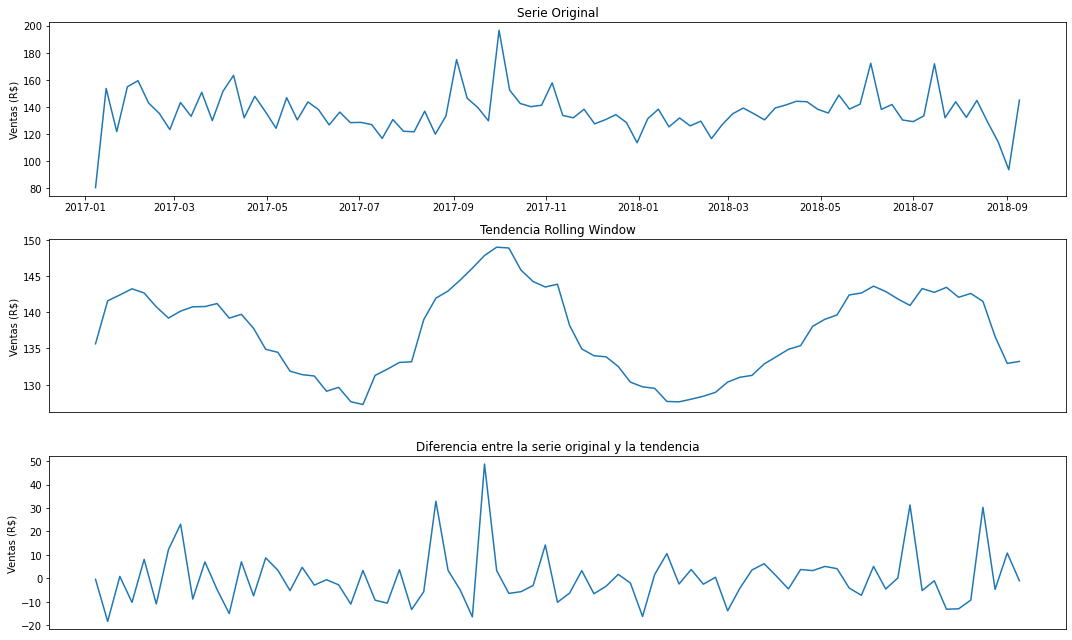

In [11]:
# Obtenemos las componentes

plt.figure(figsize = (15,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(semanal.index, semanal.y)
plt.ylabel('Ventas (R$)')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(semanal_promedio_tendencia)
plt.xticks(ticks= [])
plt.ylabel('Ventas (R$)')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(semanal.index, semanal.y - semanal_promedio_tendencia)
plt.xticks(ticks= [])
plt.ylabel('Ventas (R$)')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Ventas (R$)')

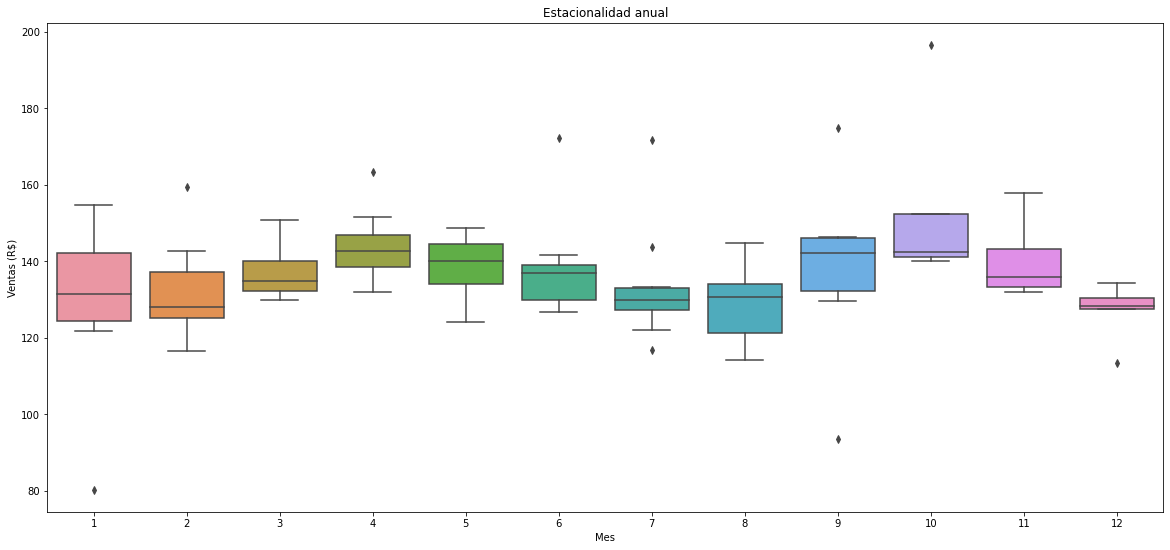

In [11]:
# Agrupamos los datos por mes y mostramos las distribuciones de cada grupo. De esta manera, se visualiza la estacionalidad anual

plt.figure(figsize = (20,9))
sns.boxplot(data=semanal,x=semanal.index.month,y= semanal.y)
plt.title('Estacionalidad anual')
plt.xlabel('Mes')
plt.ylabel('Ventas (R$)')


***Conclusiones***

Las series de tiempo pueden ser estocásticas o determinísticas. 

En este caso, al tener cierto nivel de estructura, es determinística (con lo cual, tiene un mayor grado de predictibilidad). En las series estocásticas hay un alto grado de aleatoriedad y mayor incertidumbre de lo que pueda pasar a futuro, lo cual dificulta la precisión de la predicción (ejemplo, precio del bitcoin).

Componentes de la serie de tiempo:

+ Tendencia: indica la dirección global de la serie. En este caso, la tendencia no es creciente ni decreciente, sino estacionaria en la media. Según la ventana de tiempo que se esté considerando, la tendencia puede cambiar completamente. Acá, agrupando los promedios por semana o por mes la tendencia sigue siendo la misma

+ Estacionalidad: hace referencia a los procesos que tienen comportamientos repetitivos a lo largo del tiempo. Periodicidad, patrón. Encontrar estos patrones puede ayudar a generar predicciones más acertadas. En nuestro caso, observamos un patrón sinusoidal. A su vez, hay que diferenciar si la estacionalidad es aditiva o multiplicativa (amplifica la señal cada vez que se repite el patrón). En esta ocasión, la estacionalidad es aditiva

+ Ruido blanco: secuencia de variables aleatorias no correlacionadas. Proceso que no responde específicamente a nada o no tiene un sentido concreto. Esta suele ser la parte que no se puede predecir

+ Anomalías: valores que se alejan mucho de la media. Identificarlas ayuda a a la hora de intentar encontrar los componentes de la serie (tendencia y estacionalidad). Pasar las anomalías por alto puede distorsionar los componentes y resultados de los modelos. En este caso, las anomalías se ubican en los primeros 3 meses que abarcan nuestro dataset (septiembre a diciembre de 2016)

### Modelos predictivos para series temporales 

+ Modelos clásicos : basados en métodos estadísticos-econométricos y que dominaban este campo hasta finales del siglo XX

Infieren a partir de los datos inmediatamente anteriores. A diferencia de los modelos modernos de machine learning, no tienen en cuenta la secuencia de los eventos ni los datos subsiguientes

`Procesos autoregresivos` : predice a partir de los valores de los registros anteriores (en la ventana de tiempo que se establezca)

`Procesos de media movil` :  predice a partir de los ruidos blancos de los registros anteriores

`ARMA/ARIMA` :  función que combina los dos procesos anteriores. 

Ninguno puede tener en cuenta la estacionariedad de los datos (tendencia)


+ Modelos de machine learning :

`One step` : el objetivo es predecir únicamente el siguiente valor de la serie. Si esta tuviese una frecuencia de muestreo semanal, predeciría el valor de la serie de la semana siguiente

`Multi step` : el objetivo es predecir los n valores siguientes de la serie. Se define la cantidad de steps que se quieren predecir

`Prophet` : busca estudiar los componentes de nuestras series temporales. Incluye dentro de sus algoritmos modelos de predicción, de detección de anomalías, análisis de estacionalidad para distintas granularidades temporales, estudios de tendencia, entre muchas otras opciones.

# **ETAPA 2**

### Autocorrelación

La correlación es una cuantificación de la relación entre dos variables. La autocorrelación  es la correlación de una serie consigo misma. Pero toda variable correlacionada consigo misma da 1, por lo que estaría faltando algo. Lo que falta son los *lags* (ventana temporal).

La autocorrelación se calcula con la serie de tiempo original y la misma serie desfasada o corrida en el tiempo. 

En la librería `statsmodel` esto lo logramos con la función `acf`.


In [7]:
from statsmodels.tsa.stattools import acf

nlags =  20
autocorr = acf(semanal.y, nlags = nlags)
autocorr.shape

(21,)

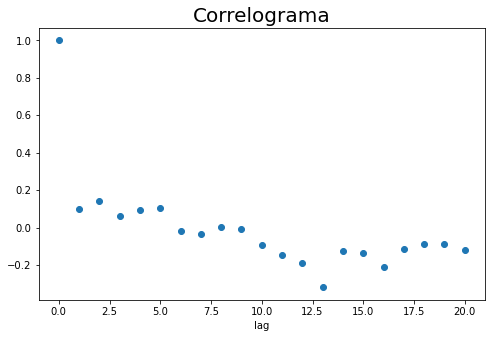

In [23]:
# Graficamos un correlograma

plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.title('Correlograma', fontsize=20)
plt.show()

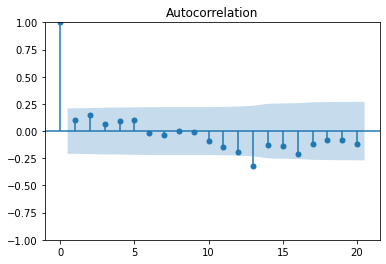

In [24]:
plot_acf(semanal.y, lags = 20)
plt.show()

Podemos observar que no hay una correlación entre el nivel de ventas de un día determinado respecto a los días anteriores. Es decir, el nivel de ventas de un día 'x' no está afectado por el nivel de día de los días anteriores.

## Forecasting

Proceso que consiste en predecir el valor futuro de una serie temporal.

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que cada valor está asociado a la ventana temporal (lags) que le precede. Esto significa que, para cada predicción, se utilizan como predictores los niveles de ventas de la cantidad de semanas establecidas como lags(ventana temporal).

Aquí comenzaremos a ver dos estrategias: one-step y multi-step


### One-Step Prediction

In [128]:
senial = semanal.y

In [129]:
#  usamos x semanas para predecir el valor siguiente

look_back = 7

In [130]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(80, 7) (80,)


In [131]:
# Llenamos los X e Y

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [132]:
N_train = 75 - look_back # cantidad de instancias anteriores que vamos a usar para entrenar. 
N_test = 12 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(68, 7) (68,)
(12, 7) (12,)


In [133]:
# Entrenamos un random forest

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

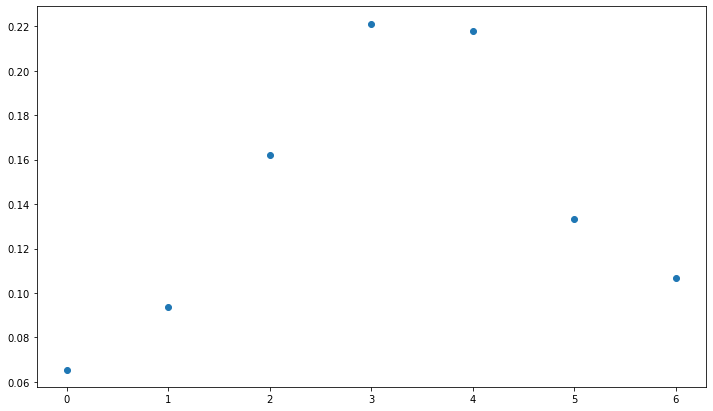

In [134]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
#for x in np.arange(3)*5:
#    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [135]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

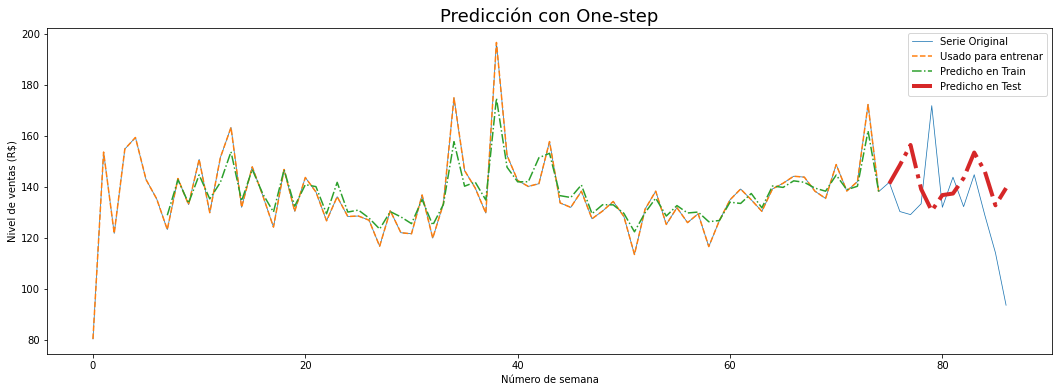

In [154]:
plt.figure(figsize=(18,6))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Número de semana')
plt.ylabel('Nivel de ventas (R$)')
plt.title('Predicción con One-step', fontsize = 18)
plt.show()

In [21]:
# Calculamos el RMSE

MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 5.3664752945744905
Error en Test: 22.037829092921957


### Modelo Benchmark

Predice basándose en el valor de la muestra anterior. -Predice que el nivel de ventas de mañana va a ser el de hoy-

In [22]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

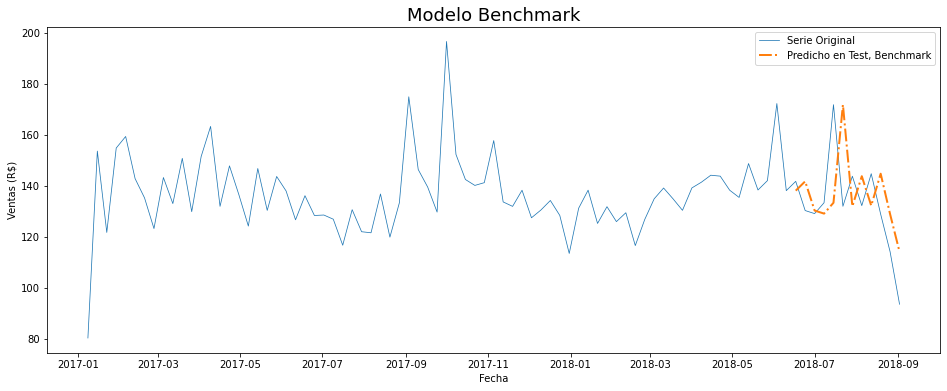

In [24]:
plt.figure(figsize=(16,6))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')

plt.xlabel('Fecha')
plt.ylabel('Ventas (R$)')
plt.legend()
plt.title('Modelo Benchmark', fontsize = 18)
plt.show()

In [25]:
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('El RMSE del modelo Benchmark es :',np.sqrt(MSE))

El RMSE del modelo Benchmark es : 19.483172424989913


### Multi-step

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ( t+1 ), sino todo un intervalo futuro o un punto alejado en el tiempo ( t+n ). A cada paso de predicción se le conoce como step.

Aquí tenemos dos métodos: recursiva o directa. La predicción recursiva se basa en la predicción anterior hecha por el modelo, mientras que el método directo entrena un modelo diferente para cada uno de lo steps que se desea predecir. Este método es mucho más costoso computacionalmente porque requiere entrenar varios modelos (uno para cada step-predicción-).

VENTAJAS DEL MÈTODO RECURSIVO :SOLO HAY QUE ENTRENAR UN MODELO. DESVENTAJAS : CUANTO MÁS NOS ALEJAMOS DE LOS DATOS MEDIDOS, MÁS PROBABLE QUE SE ACUMULEN ERRORES.

VENTAS DEL MÉTODO DIRECTO : NO ACUMULA ERROR . DESVENTAJAS : HAY QUE CREAR UN MODELO PARA CADA PASO

En el recursivo, si establecemos una ventana temporal (o ventana de predictores) de 5 para predecir, el valor t+1 va a tomar las 5 semanas anteriores. Ahora bien, cuando queramos predecir el segundo step (t+2) en los  5 lags que utiliza para predecir va a considerar t+1(que es un valor predicho)

Empezamos con el método recursivo.Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de random forest y una ventana temporal de 2 semanas (14 lags). Esto último significa que, para cada predicción, se utilizan como predictores el nivel de ventas de Olist de los 14 días anteriores.

In [137]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

Fechas train : 0 --- 75  (n=76)
Fechas test  : 76 --- 87  (n=12)


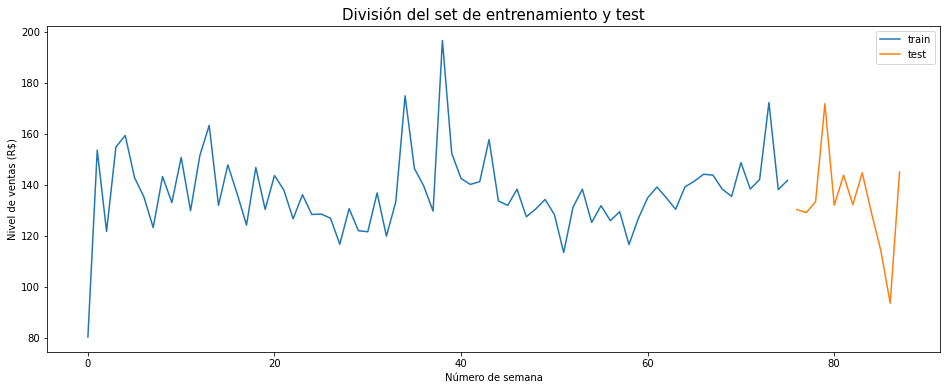

In [152]:
# Separación datos train-test
# ==============================================================================

steps = 12 # Cantidad de semanas para testear
datos_train = semanal[:-steps]
datos_test  = semanal[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

plt.subplots(figsize=(16, 6))
plt.plot(datos_train['y'], label='train')
plt.plot(datos_test['y'], label='test')
plt.xlabel('Número de semana')
plt.ylabel('Nivel de ventas (R$)')
plt.title('División del set de entrenamiento y test', fontsize = 15)
plt.legend()
plt.show()

In [139]:
print(datos_train.shape)
print(datos_test.shape)

(76, 3)
(12, 3)


In [140]:
from sklearn.ensemble import RandomForestRegressor 

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 2
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2] 
Window size: 2 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 75] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-07-28 18:51:39 
Last fit date: 2022-07-28 18:51:39 
Skforecast version: 0.4.1 

In [141]:
#Una vez entrenado el modelo, se predicen los datos de test (valor fijado en steps)
# Predicciones
# ==============================================================================

predicciones = forecaster.predict(steps= steps)
predicciones.head(5)

76    152.344442
77    139.641002
78    137.945378
79    143.251565
80    145.453973
Name: pred, dtype: float64

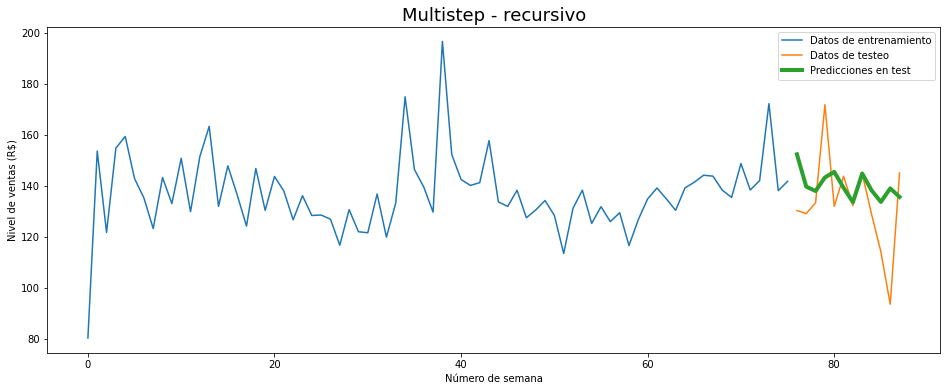

In [151]:
# Gráfico
# ==============================================================================
plt.subplots(figsize=(16, 6))
plt.plot(datos_train['y'], label='Datos de entrenamiento',)
plt.plot(datos_test['y'], label='Datos de testeo')
plt.plot(predicciones, label='Predicciones en test', lw= 4)
plt.xlabel('Número de semana')
plt.ylabel('Nivel de ventas (R$)')
plt.title('Multistep - recursivo', fontsize = 18)
plt.legend()
plt.show()

In [34]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (Rmse): {np.sqrt(error_mse)}")

Error de test (Rmse): 18.848212049701136


#### Ahora empleamos un modelo con el método directo

In [156]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 12,
                    lags      = 8
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoregMultiOutput 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Maximum steps predicted: 12 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 75] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-07-28 19:01:28 
Last fit date: 2022-07-28 19:01:30 
Skforecast version: 0.4.1 

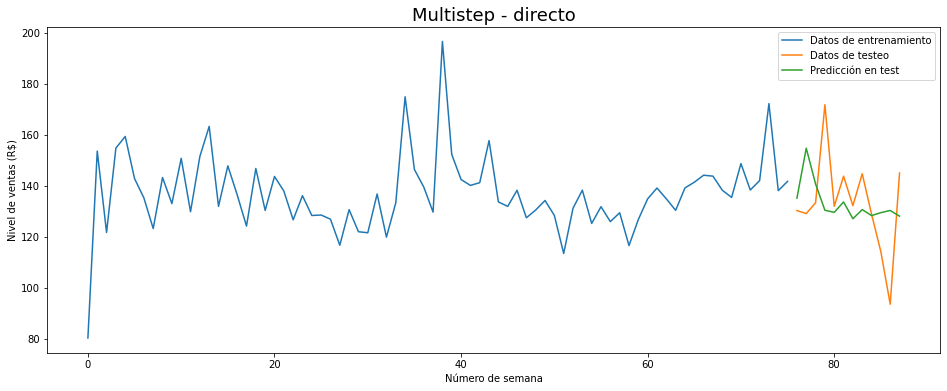

In [157]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico
# ==============================================================================
plt.subplots(figsize=(16, 6))
plt.plot(datos_train['y'], label='Datos de entrenamiento')
plt.plot(datos_test['y'], label='Datos de testeo')
plt.plot(predicciones, label='Predicción en test')
plt.title('Multistep - directo', fontsize = 18)
plt.xlabel('Número de semana')
plt.ylabel('Nivel de ventas (R$)')
plt.legend()
plt.show()


In [37]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (RMSE) : {np.sqrt(error_mse)}")

Error de test (RMSE) : 19.701401819630437


## Modelos de Prophet

Prophet utiliza un modelo de regresión aditiva para descomponer la serie temporal en varios componentes: la tendencia (trend), la estacionalidad (seasonality), los festivos (holidays) y el error:

$$y(t) = g(t) + s(t) + h(t) + e(t)$$

- $g(t)$ es la tendencia, que representa los cambios no periódicos que se modelizarán asumiendo una relación lineal o logística.

- $s(t)$ es la estacionalidad, que representa cambios periódicos: semanales, mensuales, anuales, etc.

- $h(t)$ es el efecto de los festivos, que pueden aparecer de manera irregular y tener una duración de 1 día o más.

- $e(t)$ es el término de error, que representa cambios *idiosincrásicos* que no se pueden acomodar al modelo. Se asume que estos errores deben tener una distribución normal.

In [238]:
from prophet import Prophet

# utiliza el ajuste de curvas para descomponer las series de tiempo,
#  teniendo en cuenta la estacionalidad en múltiples escalas de tiempo,
#  efectos de vacaciones, puntos de cambio abruptos y tendencias a largo plazo.

In [239]:
semanal.reset_index(level= 0, inplace= True)

In [265]:
# ARRANCAMOS CON UN MODELO SENCILLO SIN AJUSTAR HIPERPARÁMETROS

# set prophet model 
prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 50, mcmc_samples=50, interval_width= 0.6)

# fit $wmt data to model
prophet.fit(semanal)

# build future dataframe for x years
build_forecast = prophet.make_future_dataframe(periods=24, freq='W')

# forecast future df with model
forecast = prophet.predict(build_forecast)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\iomy6utf.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\44p4gn4t.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
19:41:05 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=45271', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\iomy6utf.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\44p4gn4t.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelv92pvzv5\\prophet_model-20220728194105_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=45271', 'data', 'file=C:\\Users\\leand\\A

19:41:05 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=45271', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\iomy6utf.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\44p4gn4t.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelv92pvzv5\\prophet_model-20220728194105_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelv92pvzv5\prophet_model-20220728194105_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelv92pvzv5\pro

<Figure size 1152x432 with 0 Axes>

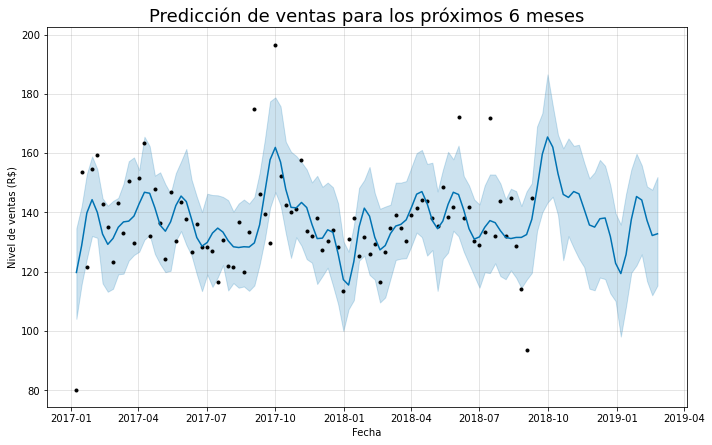

In [266]:
# plot forecasts
plt.figure(figsize=(16,6))
prophet.plot(forecast, xlabel='Fecha', ylabel='Nivel de ventas (R$)')
plt.title('Predicción de ventas para los próximos 6 meses', fontsize = 18)
plt.show()

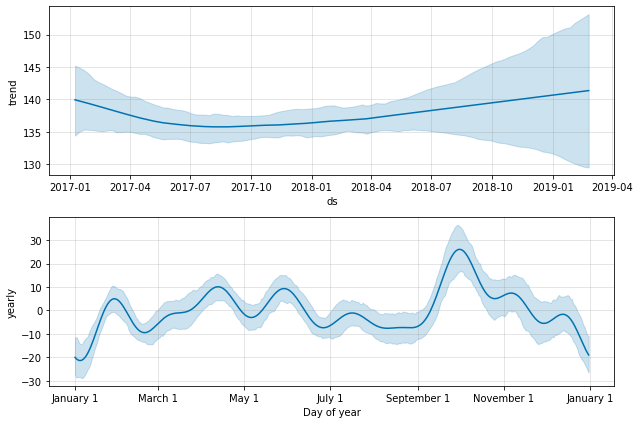

In [267]:
components = prophet.plot_components(forecast)

In [274]:
# set prophet model 
prophet = Prophet(yearly_seasonality= True, uncertainty_samples= 10000, mcmc_samples= 10000)

# fit $wmt data to model
prophet.fit(semanal)

# build future dataframe for x years
build_forecast = prophet.make_future_dataframe(periods=24, freq='W')

# forecast future df with model
forecast = prophet.predict(build_forecast)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\l7nz0p6l.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\5ztummyk.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
19:43:13 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=73420', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\l7nz0p6l.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\5ztummyk.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelays_fjrc\\prophet_model-20220728194314_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=73420', 'data', 'file=C:\\Users\\lean

19:43:28 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=73420', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\l7nz0p6l.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\5ztummyk.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelays_fjrc\\prophet_model-20220728194314_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=5000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelays_fjrc\prophet_model-20220728194314_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelays_fjrc

En esta gráfica los puntos negros indican los verdaderos valores de los precios de las acciones, la línea azul son los precios predichos por Prophet, y la zona azul claro es el intervalo de confianza de esas predicciones. Estos intervalos no enmarcan exactamente los precios verdaderos, solo indican la incertidumbre de las predicciones y si existe *overfitting*. Ahora vamos a desglosar los distintos componentes del modelo

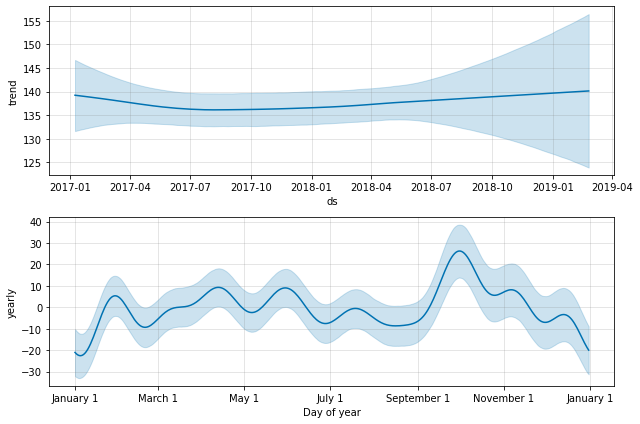

In [275]:
components = prophet.plot_components(forecast)

#### Evaluación del modelo

In [99]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [101]:
wmt_cv = cross_validation(prophet, horizon = '19 days')

prophet    INFO  Making 24 forecasts with cutoffs between 2018-01-14 12:00:00 and 2018-08-21 00:00:00


  0%|          | 0/24 [00:00<?, ?it/s]

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\eeibzf0o.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\4wh5scs4.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:48 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=39105', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\eeibzf0o.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\4wh5scs4.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelsudrs85w\\prophet_model-20220728183648_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:49 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=39105', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\eeibzf0o.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\4wh5scs4.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelsudrs85w\\prophet_model-20220728183648_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelsudrs85w\prophet_model-20220728183648_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelsudrs85w\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\oqbp4_rj.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\agx1_dnc.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:49 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=33727', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\oqbp4_rj.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\agx1_dnc.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelf9b3qewj\\prophet_model-20220728183649_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:49 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=33727', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\oqbp4_rj.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\agx1_dnc.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelf9b3qewj\\prophet_model-20220728183649_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelf9b3qewj\prophet_model-20220728183649_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelf9b3qewj\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\f54xp56a.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\cf9q5qmi.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:49 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=25266', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\f54xp56a.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cf9q5qmi.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modellrtsxzms\\prophet_model-20220728183649_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=25266', 'data', 'file=C:\\Users\\leand\\A

18:36:50 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=25266', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\f54xp56a.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cf9q5qmi.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modellrtsxzms\\prophet_model-20220728183649_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modellrtsxzms\prophet_model-20220728183649_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modellrtsxzms\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\4q4pvcp0.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\qxg7ywaz.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:50 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=62410', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\4q4pvcp0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qxg7ywaz.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelo0gkxmyh\\prophet_model-20220728183650_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=62410', 'data', 'file=C:\\Users\\leand\\A

18:36:50 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=62410', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\4q4pvcp0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qxg7ywaz.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelo0gkxmyh\\prophet_model-20220728183650_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelo0gkxmyh\prophet_model-20220728183650_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelo0gkxmyh\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\1w3yongd.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\2zhbo6lf.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:51 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=52116', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\1w3yongd.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\2zhbo6lf.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_models0rtyfdl\\prophet_model-20220728183651_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=52116', 'data', 'file=C:\\Users\\leand\\A

18:36:51 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=52116', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\1w3yongd.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\2zhbo6lf.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_models0rtyfdl\\prophet_model-20220728183651_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_models0rtyfdl\prophet_model-20220728183651_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_models0rtyfdl\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\95cwlwfd.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ut5tgdtl.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:51 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=41439', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\95cwlwfd.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ut5tgdtl.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model9975hanl\\prophet_model-20220728183651_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=41439', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\95cwlwfd.json',

18:36:51 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=41439', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\95cwlwfd.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ut5tgdtl.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model9975hanl\\prophet_model-20220728183651_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model9975hanl\prophet_model-20220728183651_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model9975hanl\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\xxk_hyfj.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\rjz9mwe6.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:52 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=93856', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\xxk_hyfj.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\rjz9mwe6.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model2faeiwtx\\prophet_model-20220728183652_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:52 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=93856', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\xxk_hyfj.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\rjz9mwe6.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model2faeiwtx\\prophet_model-20220728183652_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model2faeiwtx\prophet_model-20220728183652_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model2faeiwtx\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\zo1nanuq.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\c99jcboi.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:52 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31748', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\zo1nanuq.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\c99jcboi.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeltw4heuvk\\prophet_model-20220728183652_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:52 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31748', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\zo1nanuq.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\c99jcboi.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeltw4heuvk\\prophet_model-20220728183652_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeltw4heuvk\prophet_model-20220728183652_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeltw4heuvk\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\uqxk_z22.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ggry69_7.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:53 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=73948', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\uqxk_z22.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ggry69_7.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model9dk0h63n\\prophet_model-20220728183653_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:53 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=73948', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\uqxk_z22.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ggry69_7.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model9dk0h63n\\prophet_model-20220728183653_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model9dk0h63n\prophet_model-20220728183653_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model9dk0h63n\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\nnqyqeg9.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\1g1k0dqy.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:54 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=48449', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\nnqyqeg9.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\1g1k0dqy.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model3bfk25xw\\prophet_model-20220728183654_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=48449', 'data', 'file=C:\\Users\\leand\\A

18:36:54 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=48449', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\nnqyqeg9.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\1g1k0dqy.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model3bfk25xw\\prophet_model-20220728183654_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model3bfk25xw\prophet_model-20220728183654_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model3bfk25xw\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\3f5twpjh.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\tmq4gubz.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:54 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=34976', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\3f5twpjh.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\tmq4gubz.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelbyizhf47\\prophet_model-20220728183654_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:54 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=34976', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\3f5twpjh.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\tmq4gubz.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelbyizhf47\\prophet_model-20220728183654_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelbyizhf47\prophet_model-20220728183654_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelbyizhf47\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\vsq64il5.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\v2bln68e.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:55 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=61939', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\vsq64il5.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\v2bln68e.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeln85tj197\\prophet_model-20220728183655_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:55 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=61939', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\vsq64il5.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\v2bln68e.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeln85tj197\\prophet_model-20220728183655_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeln85tj197\prophet_model-20220728183655_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeln85tj197\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\r0z1wham.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\smq3abrt.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:55 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=40351', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\r0z1wham.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\smq3abrt.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelyr3bsgw3\\prophet_model-20220728183655_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=40351', 'data', 'file=C:\\Users\\leand\\A

18:36:56 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=40351', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\r0z1wham.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\smq3abrt.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelyr3bsgw3\\prophet_model-20220728183655_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelyr3bsgw3\prophet_model-20220728183655_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelyr3bsgw3\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\qw4r4axx.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\90kh4jl9.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:56 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=23728', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qw4r4axx.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\90kh4jl9.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelvzftmho7\\prophet_model-20220728183656_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:36:56 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=23728', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qw4r4axx.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\90kh4jl9.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelvzftmho7\\prophet_model-20220728183656_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelvzftmho7\prophet_model-20220728183656_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelvzftmho7\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\o3_qxl_g.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\8ga7merm.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:57 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=4', 'random', 'seed=50022', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\o3_qxl_g.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\8ga7merm.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelqaeyxi_5\\prophet_model-20220728183657_4.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=50022', 'data', 'file=C:\\Users\\leand\\A

18:36:57 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=50022', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\o3_qxl_g.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\8ga7merm.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelqaeyxi_5\\prophet_model-20220728183657_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelqaeyxi_5\prophet_model-20220728183657_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelqaeyxi_5\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\b32wguq0.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\7lef8w30.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:57 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=41496', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\b32wguq0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\7lef8w30.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelaw5e13jv\\prophet_model-20220728183658_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=41496', 'data', 'file=C:\\Users\\leand\\A

18:36:58 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=41496', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\b32wguq0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\7lef8w30.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelaw5e13jv\\prophet_model-20220728183658_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelaw5e13jv\prophet_model-20220728183658_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelaw5e13jv\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\fmzc8vmw.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\5x3isy7p.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:58 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=4825', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\fmzc8vmw.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\5x3isy7p.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelx17yjih8\\prophet_model-20220728183658_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random',

18:36:58 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=4825', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\fmzc8vmw.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\5x3isy7p.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelx17yjih8\\prophet_model-20220728183658_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelx17yjih8\prophet_model-20220728183658_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelx17yjih8\prop

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\cokw_c_4.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\e54gx0df.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:59 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=11931', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cokw_c_4.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\e54gx0df.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelkrd22vyf\\prophet_model-20220728183659_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=11931', 'data', 'file=C:\\Users\\leand\\A

18:36:59 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=11931', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cokw_c_4.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\e54gx0df.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelkrd22vyf\\prophet_model-20220728183659_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelkrd22vyf\prophet_model-20220728183659_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelkrd22vyf\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\pkl4jwdh.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\_rtaogtx.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:36:59 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=87295', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\pkl4jwdh.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\_rtaogtx.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeltkyqddf1\\prophet_model-20220728183659_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=87295', 'data', 'file=C:\\Users\\leand\\A

18:36:59 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=87295', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\pkl4jwdh.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\_rtaogtx.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modeltkyqddf1\\prophet_model-20220728183659_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeltkyqddf1\prophet_model-20220728183659_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modeltkyqddf1\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\nnjyj8kl.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\qtid1r6s.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:00 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=78003', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\nnjyj8kl.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qtid1r6s.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelk6_2tcgb\\prophet_model-20220728183700_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=78003', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\nnjyj8kl.json',

18:37:00 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=78003', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\nnjyj8kl.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qtid1r6s.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelk6_2tcgb\\prophet_model-20220728183700_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelk6_2tcgb\prophet_model-20220728183700_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelk6_2tcgb\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\_qjqj68u.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\u79kvx86.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:00 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=5415', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\_qjqj68u.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\u79kvx86.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelv2hbeozt\\prophet_model-20220728183701_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random',

18:37:01 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=5415', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\_qjqj68u.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\u79kvx86.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelv2hbeozt\\prophet_model-20220728183701_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelv2hbeozt\prophet_model-20220728183701_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelv2hbeozt\prop

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\pnj7hbp0.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\mss32any.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:01 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=26798', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\pnj7hbp0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\mss32any.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model4yiiaii0\\prophet_model-20220728183701_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=26798', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\pnj7hbp0.json',

18:37:01 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=26798', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\pnj7hbp0.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\mss32any.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_model4yiiaii0\\prophet_model-20220728183701_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model4yiiaii0\prophet_model-20220728183701_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_model4yiiaii0\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\z3mxx7ls.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\upeajcs5.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:02 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=22066', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\z3mxx7ls.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\upeajcs5.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelhry1e0ac\\prophet_model-20220728183702_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=22066', 'data', 'file=C:\\Users\\leand\\A

18:37:02 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=22066', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\z3mxx7ls.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\upeajcs5.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelhry1e0ac\\prophet_model-20220728183702_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelhry1e0ac\prophet_model-20220728183702_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelhry1e0ac\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ds6013c8.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\gkt5zc2e.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:02 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=8431', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ds6013c8.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\gkt5zc2e.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelm666pc3f\\prophet_model-20220728183702_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random',

18:37:02 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=8431', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ds6013c8.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\gkt5zc2e.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelm666pc3f\\prophet_model-20220728183702_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelm666pc3f\prophet_model-20220728183702_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelm666pc3f\prop

In [102]:
df_p = performance_metrics(wmt_cv)
df_p.describe()

horizon          mse       rmse        mae  \
count                         36    36.000000  36.000000  36.000000   
mean            10 days 06:00:00   425.043813  19.561530  14.033654   
std    5 days 06:25:40.242123238   262.754272   6.603143   4.426035   
min              1 days 12:00:00    34.297886   5.856440   4.155291   
25%              5 days 21:00:00   197.526457  14.050849  10.392089   
50%             10 days 06:00:00   391.474953  19.785042  14.096229   
75%             14 days 15:00:00   557.913778  23.618560  16.540198   
max             19 days 00:00:00  1154.947352  33.984516  24.127036   

            mape      mdape      smape   coverage  
count  36.000000  36.000000  36.000000  36.000000  
mean    0.106069   0.066944   0.099901   0.791667  
std     0.038573   0.025810   0.031368   0.129866  
min     0.030332   0.022979   0.030876   0.500000  
25%     0.078077   0.046824   0.074360   0.666667  
50%     0.099848   0.063914   0.098565   0.833333  
75%     0.132172   0.080525   0.122020   0.833333  
max     0.212476   0.141844   0.177820   1.000000

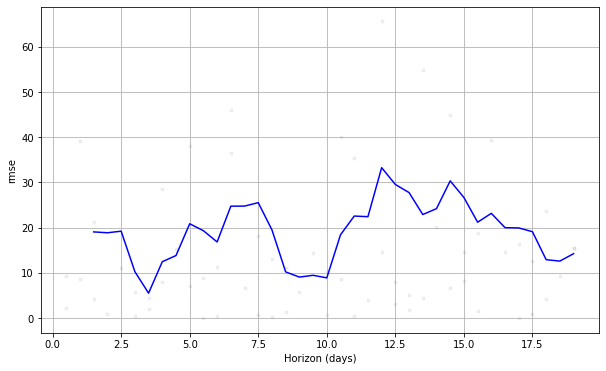

In [79]:
fig = plot_cross_validation_metric(wmt_cv, metric='rmse')

In [106]:
df_cv = cross_validation(prophet, horizon = '88 days', period= '88 days')

prophet    INFO  Making 2 forecasts with cutoffs between 2018-03-17 00:00:00 and 2018-06-13 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\y53rf5h6.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\v8y6vhkf.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:40 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=10298', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\y53rf5h6.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\v8y6vhkf.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelzdzajv5g\\prophet_model-20220728183740_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random'

18:37:40 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=10298', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\y53rf5h6.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\v8y6vhkf.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelzdzajv5g\\prophet_model-20220728183740_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelzdzajv5g\prophet_model-20220728183740_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelzdzajv5g\pro

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\cda94bz6.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ya1jgiue.json
cmdstanpy  DEBUG cmd: C:\Users\leand\miniconda3\envs\time_series\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
18:37:41 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=96028', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cda94bz6.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ya1jgiue.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelw1g1d7ju\\prophet_model-20220728183741_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=96028', 'data', 'file=C:\\Users\\leand\\A

18:37:41 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=96028', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\cda94bz6.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ya1jgiue.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\prophet_modelw1g1d7ju\\prophet_model-20220728183741_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelw1g1d7ju\prophet_model-20220728183741_1.csv
 console_msgs (if any):
	C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\prophet_modelw1g1d7ju\pro

In [104]:
wmt_pm = performance_metrics(df_cv)
wmt_pm.describe()

horizon          mse       rmse        mae  \
count                          25    25.000000  25.000000  25.000000   
mean             46 days 05:45:36   435.725503  15.423382  14.120432   
std    25 days 18:15:12.744807829   741.410249  14.355777  13.333551   
min               4 days 00:00:00     2.494989   1.579553   1.304858   
25%              25 days 00:00:00    23.644692   4.862581   4.858878   
50%              46 days 00:00:00   124.161642  11.142784  11.130682   
75%              67 days 00:00:00   336.865517  18.353897  18.146832   
max              88 days 00:00:00  2952.019098  54.332487  53.668824   

            mape      mdape      smape   coverage  
count  25.000000  25.000000  25.000000  25.000000  
mean    0.107428   0.107428   0.103599   0.840000  
std     0.114261   0.114261   0.098670   0.313581  
min     0.009479   0.009479   0.009414   0.000000  
25%     0.035835   0.035835   0.035744   1.000000  
50%     0.078776   0.078776   0.079342   1.000000  
75%     0.123454   0.123454   0.131753   1.000000  
max     0.463366   0.463366   0.400373   1.000000

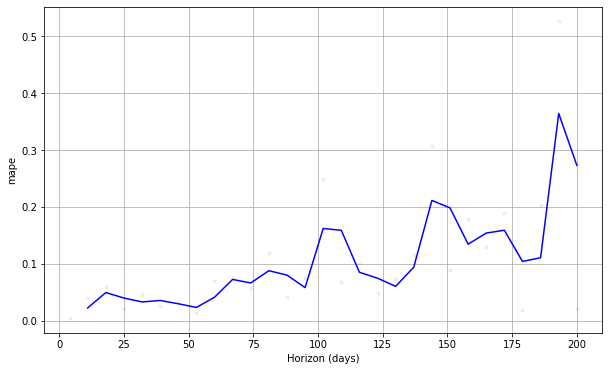

In [249]:
# MAPE (Mean Absolute Percentage Error, error porcentual absoluto medio) para determinar el error

fig = plot_cross_validation_metric(wmt_cv, metric='mape')

***Como observamos, se estima un error en la predicciones entre el 2% y el 32%***

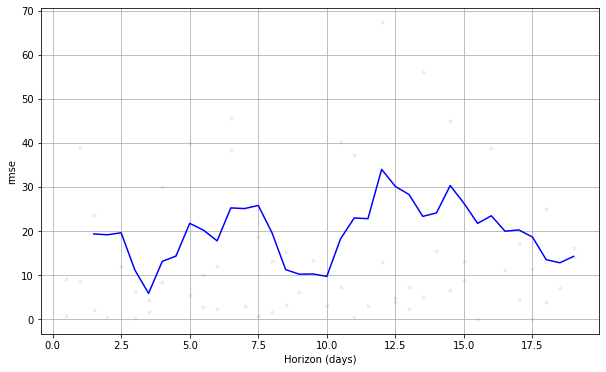

In [107]:
fig = plot_cross_validation_metric(wmt_cv, metric='rmse')

## OPTIMIZACIÓN DE HIPERPARÁMETROS

In [108]:
import datetime
start = datetime.date(2018,9,16)
periods = 24
daterange = []
for weeks in range(periods):
  date = (start + datetime.timedelta(weeks = weeks)).isoformat()
  daterange.append(date)
print(daterange)

['2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07', '2018-10-14', '2018-10-21', '2018-10-28', '2018-11-04', '2018-11-11', '2018-11-18', '2018-11-25', '2018-12-02', '2018-12-09', '2018-12-16', '2018-12-23', '2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24']


In [109]:
#Creamos dataframe para las fechas de predicciones futuras

futuro = pd.DataFrame({'ds': pd.to_datetime(
    [x for x in daterange]), 'y': np.nan})

In [110]:
futuro.head(2)

ds   y
0 2018-09-16 NaN
1 2018-09-23 NaN

In [111]:
train = semanal.copy()

In [18]:
import itertools
from multiprocessing import process
from tkinter import Message

#Creamos la grilla
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'interval_width' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'daily_seasonality' : [True, False],
    'weekly_seasonality' : [True, False],
    'yearly_seasonality' : [True, False],
    'uncertainty_samples' : [10, 20, 40, 60, 100, 200, 300]}

#generamos todas las combinaciones
all_params = [dict(zip(param_grid.keys(), v))
            for v in itertools.product(*param_grid.values())]

rmse = []


for params in all_params:
    m = Prophet(**params)

    m.fit(train)

    #Haremos predicciones para el horizon especificado

    df_cv = cross_validation(
        m, initial = '200 days', horizon = '180 days', parallel= 'processes')
    df_p = performance_metrics(df_cv, rolling_window = 1)

    rmse.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmse


best_params = all_params[np.argmin(rmse)]


cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\by4q1k2p.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\sezqn8c1.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=64367', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\by4q1k2p.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\sezqn8c1.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmpu38smknd\\prophet_model-20220728121810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:18:10 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing
cm

In [27]:
best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 1.0,
 'interval_width': 0.1,
 'daily_seasonality': False,
 'weekly_seasonality': True,
 'yearly_seasonality': False,
 'uncertainty_samples': 10}

In [187]:
# En cross validation, initial es el periodo del dataset que le vamos a asignar a train. Mientras que horizon define la cantidad de tiempo que queremos predecir. (Entre los dos
# no se debe superar la cantidad total de días del set)
#  Period es cómo se va a ir moviendo la ventana de train y test

print('Cantidad de días del dataset : ', semanal.ds[87] - semanal.ds[0])

Cantidad de días del dataset :  609 days 00:00:00


In [246]:
# Corremos modelo con best_params

#instanciamos el modelo
m = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 1.0, interval_width = 0.1,
daily_seasonality = False,  weekly_seasonality = True,  yearly_seasonality = False, uncertainty_samples = 10)

#entrenamos con el dataset de entrenamiento
m.fit(train)

#predecimos en el dataset de futuro
forecast = m.predict(futuro)

#para graficar, hacemos predict también en train
forecast_train = m.predict(train)

#unimos para poder visualizar las dos partes
forecast_final = pd.concat([forecast_train, forecast])

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\gde213zp.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\8dr0r8pl.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=48428', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\gde213zp.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\8dr0r8pl.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp5xfpbv_v\\prophet_model-20220728193911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:39:11 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
19:39:12 - cmdstanpy - INFO - Chain [1] done processing
cmdst

In [286]:
df_cv = cross_validation(
m, initial = '200 days', horizon = '180 days', parallel= 'processes')
df_p = performance_metrics(df_cv, rolling_window = 1)

prophet    INFO  Making 3 forecasts with cutoffs between 2017-09-14 00:00:00 and 2018-03-13 00:00:00
prophet    INFO  Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002A78653A290>


In [287]:
df_p

horizon         mse       rmse       mae      mape     mdape     smape  \
0 180 days  200.578212  14.162564  9.373749  0.068439  0.045862  0.067983   

   coverage  
0  0.692308

Text(0.5, 1.0, 'Mean Absolute Percentage Error')

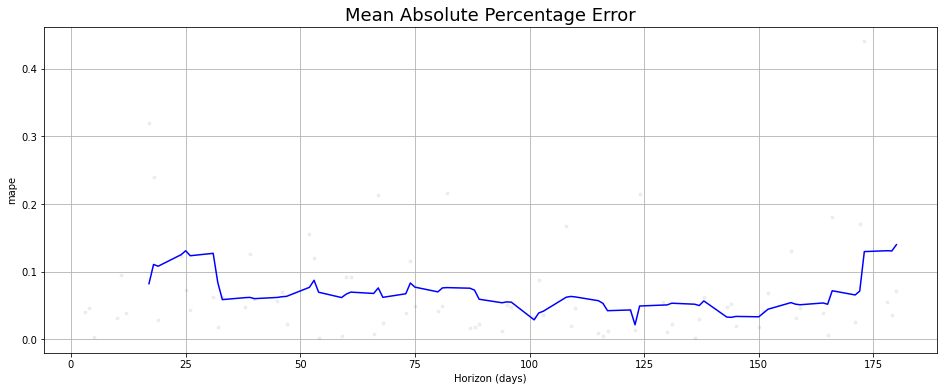

In [295]:
fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=(16,6), color = 'b')
plt.title('Mean Absolute Percentage Error', fontsize = 18)

Text(0.5, 1.0, 'Root Mean Squared Error')

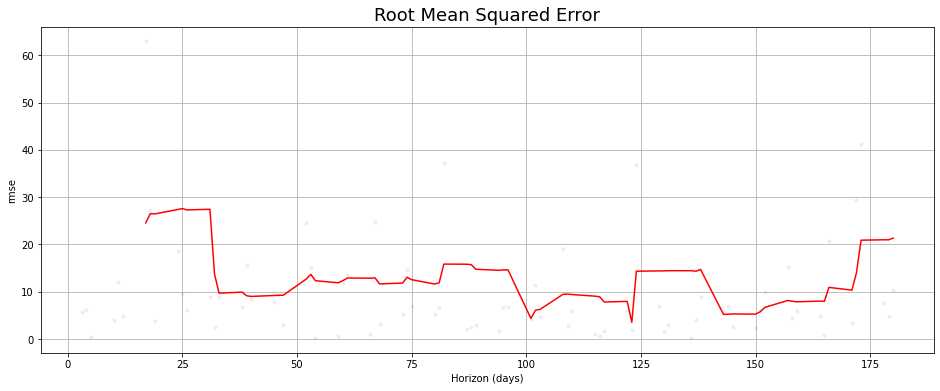

In [296]:
fig = plot_cross_validation_metric(df_cv, metric='rmse', figsize=(16,6), color = 'r')
plt.title('Root Mean Squared Error', fontsize = 18)

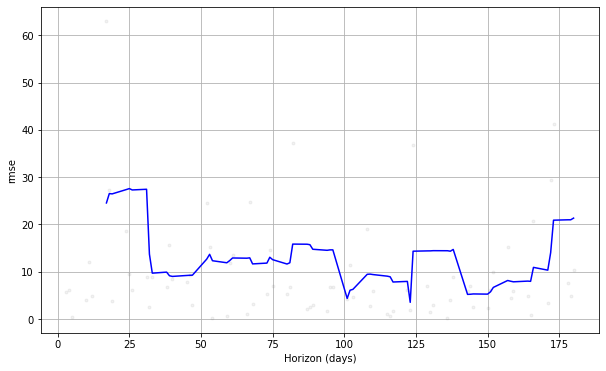

In [281]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

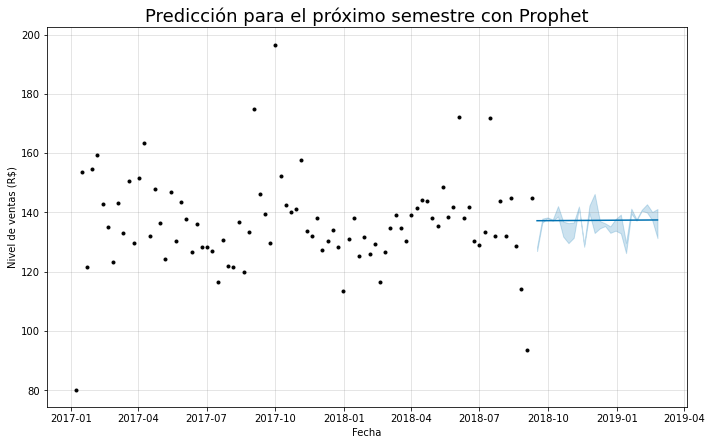

In [115]:
m.plot(forecast, xlabel='Fecha', ylabel='Nivel de ventas (R$)')
plt.title('Predicción para el próximo semestre con Prophet', fontsize = 18)
plt.show()

#### Corremos con otros hiperparámetros

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\x1gou0gj.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\0ew8hbye.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=88737', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\x1gou0gj.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\0ew8hbye.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp9gs8srf1\\prophet_model-20220728194006.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:40:06 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
19:40:07 - cmdstanpy - INFO - Chain [1] done processing
cmdst

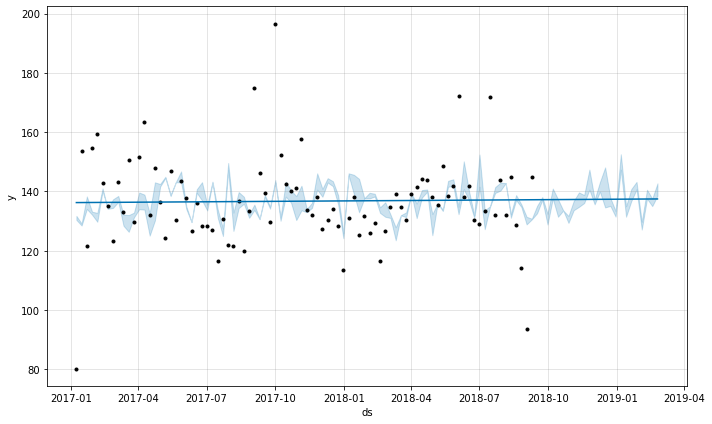

In [249]:
m = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 1.0, interval_width = 0.1,
daily_seasonality = False,  weekly_seasonality = True,  yearly_seasonality = False, uncertainty_samples = 10)
m.fit(train)
future = m.make_future_dataframe(periods=24, freq="W")
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [253]:
m = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 1.0, interval_width = 0.1,
daily_seasonality = False,  weekly_seasonality = True,  yearly_seasonality = False, uncertainty_samples = 10)
m.fit(semanal)
future = m.make_future_dataframe(periods=24, freq="W")
forecast = m.predict(future)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\7dqhre2u.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\qtyz78pf.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=86866', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\7dqhre2u.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\qtyz78pf.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmpzb6xs0zr\\prophet_model-20220728194017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:40:17 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
19:40:19 - cmdstanpy - INFO - Chain [1] done processing
cmdst

EL QUE ESTABA TRABAJANDO ANTES

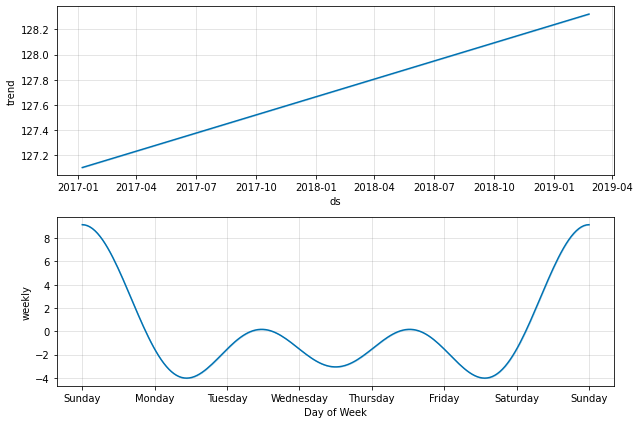

In [252]:
fig2 = m.plot_components(forecast)

In [259]:
m = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 1.0, interval_width = 0.5,
daily_seasonality = False,  weekly_seasonality = True,  yearly_seasonality = False, uncertainty_samples = 10)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path


In [260]:
m.fit(semanal)

cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ttky5syg.json
cmdstanpy  DEBUG input tempfile: C:\Users\leand\AppData\Local\Temp\tmp40iwl3tp\ofebcjon.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\leand\\miniconda3\\envs\\time_series\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=70875', 'data', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ttky5syg.json', 'init=C:\\Users\\leand\\AppData\\Local\\Temp\\tmp40iwl3tp\\ofebcjon.json', 'output', 'file=C:\\Users\\leand\\AppData\\Local\\Temp\\tmpummfw_8z\\prophet_model-20220728194036.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:40:36 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
19:40:38 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


In [261]:
future = m.make_future_dataframe(periods = 24, freq= 'W')

In [262]:
forecast = m.predict(future)

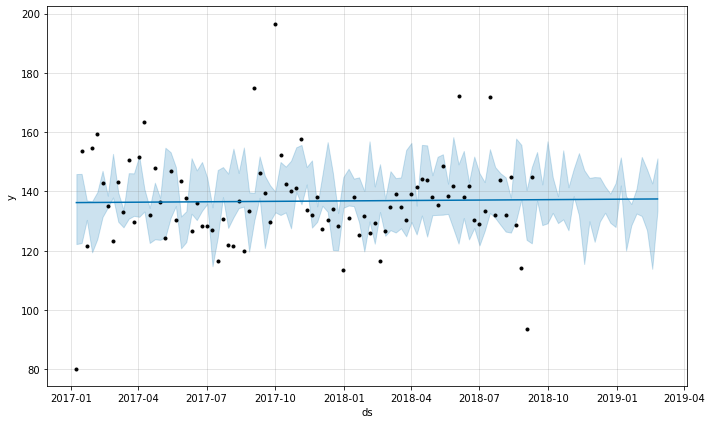

In [263]:
fig1 = m.plot(forecast)

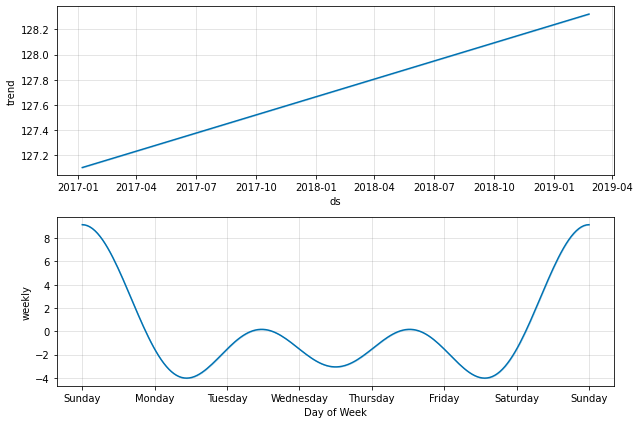

In [264]:
fig2 = m.plot_components(forecast)

In [210]:
df_cv = cross_validation(
m, initial = '200 days', horizon = '180 days', parallel= 'processes')
df_p = performance_metrics(df_cv, rolling_window = 1)

prophet    INFO  Making 3 forecasts with cutoffs between 2017-09-14 00:00:00 and 2018-03-13 00:00:00
prophet    INFO  Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002A78093AB90>


In [211]:
df_p

horizon         mse       rmse       mae      mape     mdape     smape  \
0 180 days  200.578212  14.162564  9.373749  0.068439  0.045862  0.067983   

   coverage  
0  0.602564